In [290]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [291]:
from helper_functions import  *

# PL 

In [292]:

def generate_PL(raw_prediction, min_len=40, max_len=2500):
    from functools import lru_cache

    df = pd.DataFrame( [ ( ac, len(raw_pred), any( x[2]>=40 for x in reg_list) )
                         for ac, raw_pred, reg_list in raw_prediction ]
                      , columns=["ac", "len", "dis"])
    df.set_index('ac', inplace=True)
    df = df[(df.len >= min_len) & (df.len<=2500)]
    
    @lru_cache(maxsize=None)
    def _PL(L):
        eps = round(0.1*L)
        return df[ (df.len >= L-eps) & (df.len <= L+eps) ].mean().dis
        
    _PL.df = df
    _PL.raw = df.groupby('len').mean()  # da bi kasnije mogao da se referisem na njega
    
    return _PL
  

In [293]:
import pickle

with open('data/predictions/vsl2b_valid.pickle', 'rb') as f:
    vsl2b_valid = pickle.load(f)
    PL = generate_PL(vsl2b_valid)

with open('data/predictions/vsl2b_random.pickle', 'rb') as fr:
    vsl2b_random = pickle.load(fr)
    PL_random = generate_PL(vsl2b_random)

with open('data/predictions/vsl2b_uniform.pickle', 'rb') as fu:
    vsl2b_uniform = pickle.load(fu)
    PL_uniform = generate_PL(vsl2b_uniform)

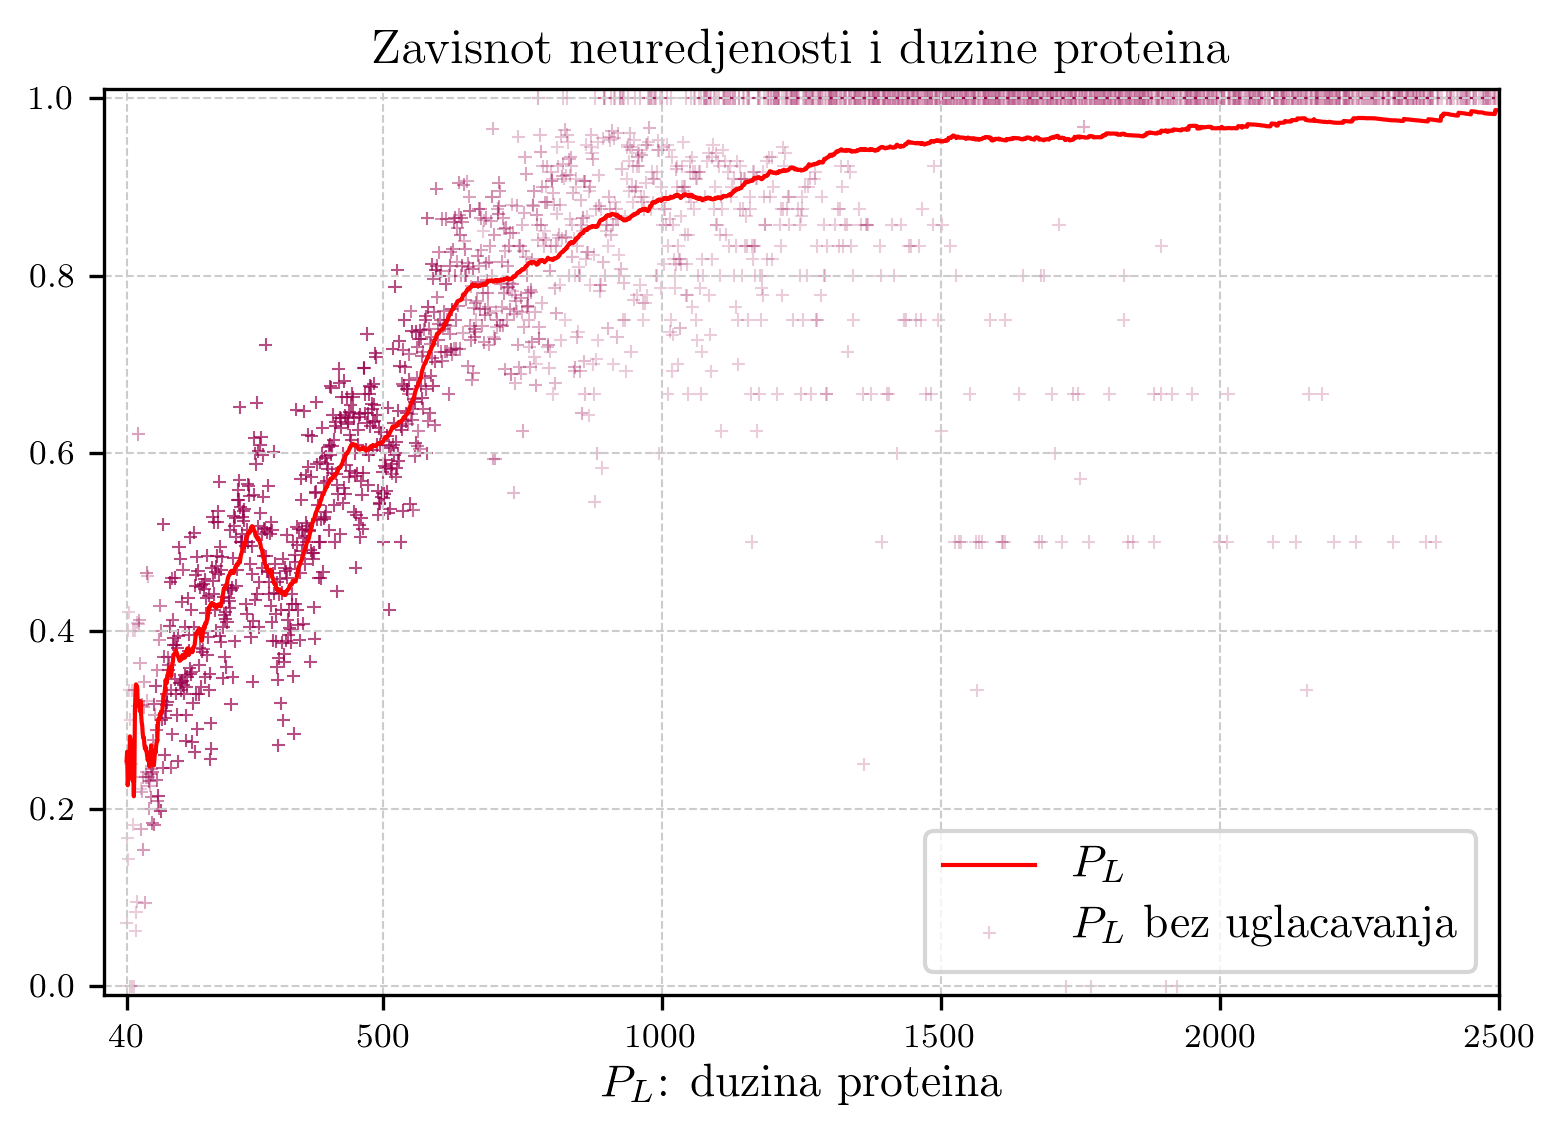

In [312]:
fig, ax = plt.subplots() 
fig.set_dpi(300)

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])

plt.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')

xs_count = PL.df.groupby('len').count().dis
xs_color = [(0.6,0,0.3, max(min(n/100,0.7),0.2) ) for n in xs_count]
plt.scatter( PL.raw.index,  PL.raw.dis, label='$P_L$ bez uglacavanja'
            , marker='+', color=xs_color, linewidth=0.5, s=10)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnot neuredjenosti i duzine proteina')
ax.set_xlabel("$P_L$: duzina proteina")

plt.legend()

#plt.savefig('plots/PL_F.pdf')

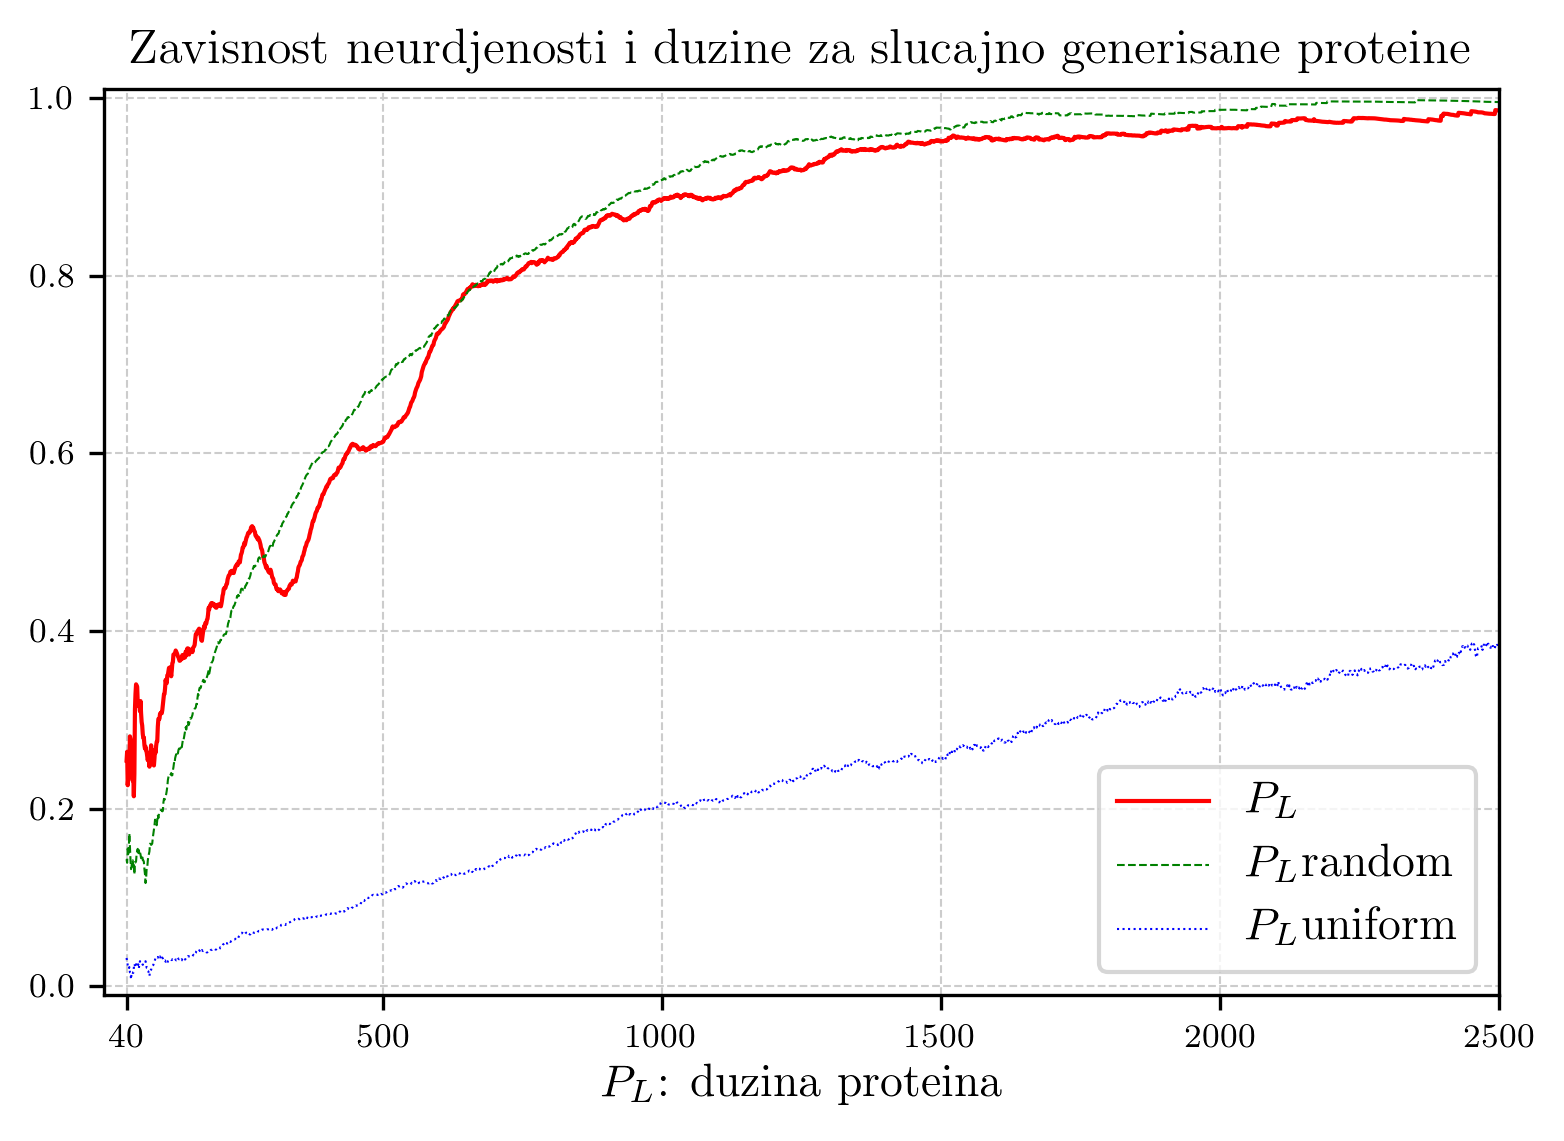

In [311]:
fig, ax = plt.subplots() 
fig.set_dpi(300)

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])
ys_random = np.array([PL_random(x) for x in xs])
ys_uniform = np.array([PL_uniform(x) for x in xs])

plt.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')
plt.plot(xs, ys_random, 'g--', linewidth=0.5, label='$P_L$random')
plt.plot(xs, ys_uniform, 'b:', linewidth=0.5, label='$P_L$uniform')

#setFigSize(fig, 10)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnost neurdjenosti i duzine za slucajno generisane proteine')
ax.set_xlabel("$P_L$: duzina proteina")

plt.legend(loc='lower right' )

plt.savefig('plots/PL_F_cmp.pdf')


# Dis

In [238]:
seq_pred = pd.read_csv("data/IN/seq_pred.csv", index_col=0)
seq2kw = pd.read_csv("data/IN/seq2kw.csv", index_col=0)

In [239]:
seq_pred['PL'] = [PL(l) for l in seq_pred.len]
seq_pred['PL_random'] = [PL_random(l) for l in seq_pred.len]
seq_pred['PL_uniform'] = [PL_uniform(l) for l in seq_pred.len]

In [240]:
seq_pred.head()

,len,dis,dis_random,dis_uniform,PL,PL_random,PL_uniform
ac,,,,,,,
A0A060X6Z0,489,True,True,False,0.610074,0.676294,0.103205
A0A068FIK2,1033,True,True,False,0.887305,0.917176,0.203666
A0A075F932,421,False,False,False,0.583323,0.626727,0.083262
A0A078CGE6,1299,True,True,False,0.934078,0.955307,0.245810
A0A086F3E3,192,True,True,False,0.431317,0.364061,0.041028


In [264]:
kw2pred = seq_pred.join(seq2kw).set_index('kw') [['len', 'dis', 'PL']]
kw2pred.head()

,len,dis,PL
kw,,,
KW-0127,489,True,0.610074
KW-0408,489,True,0.610074
KW-0479,489,True,0.610074
KW-0503,489,True,0.610074
KW-0530,489,True,0.610074


In [265]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [313]:
%%cython --annotate

from libc.stdlib cimport rand, RAND_MAX

cdef float random():
    return rand() / float(RAND_MAX)

cpdef float calc_Yj(PL_list):
    cdef int i=0
    cdef int n = len(PL_list)

    cdef float pl
    for pl in PL_list:
        if random() < pl:
            i += 1

    return float(i)/n

In [278]:
import scipy.stats as st

def calc_stat(Fj, PL_list, n=1000):
    Yj_realisations = ((PL_list) for x in range(n))
    xs = np.array([Fj<Yj for Yj in Yj_realisations])  
    mean, std = xs.mean(), xs.std()
    
    pos = Fj - mean
    z =  0 if  pos == 0 or std == 0 else pos/std

    return mean, std, z

In [279]:
from tqdm import tqdm

kw_stat_df = []

kw_groupbed = kw2pred.groupby('kw')
for kw, df in tqdm(kw_groupbed, total=len(kw_groupbed)):
    n, avg_len, Fj= len(df), df.len.mean(), df.dis.mean()
    if n < 20:
        continue
    p, std, z= calc_stat(Fj, df.PL.values)
    kw_stat_df.append((kw, n, avg_len, Fj, p, std, z))
    
kw_stat_df = pd.DataFrame(kw_stat_df, columns=['kw', 'n', 'avg_len', 'dis', 'p', 'std', 'z']).set_index('kw')

100%|██████████| 1110/1110 [00:12<00:00, 90.08it/s]


In [289]:
kw_stat_df.loc['KW-0456']

n          1433.000000
avg_len     480.715283
dis           0.640614
p             0.288207
std           0.452928
z             0.778066
Name: KW-0456, dtype: float64


Cardgin

